In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import db
import pam
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq as s2s

import time

In [2]:
DATA_PATH = "data/laurier/"
DATA_BASE = DATA_PATH + "laurier.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "laurier.jpg"
VIDEO_PATH = DATA_PATH + "laurier.avi"
HOMOGRAPHY = DATA_PATH + "laurier-homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

### Load trajectories from path

In [3]:
# get every trajectories in the database
trajectories_u = db.get_trajectories(DATA_BASE)

# number of best trajectories to keep for each object
nb_trajectories_per_object = 10

#trajectories ordered by object, database trajectory ids ordered by objects
trajectories_po,ids_po,nb_objects = db.get_trajectories_by_object(DATA_BASE)
trajectories_po,ids_po = db.filter_trajectories(nb_trajectories_per_object, trajectories_po, ids_po)
pixel_trajectories_po = [[ut.to_pixel(t,HOMOGRAPHY) for t in trajectories] for trajectories in trajectories_po]

#total number of selected trajectories
nb_trajectories = nb_trajectories_per_object * nb_objects

# list of every selected trajectory, 
trajectories = [t for o in trajectories_po for t in o]
# ids of every selected trajectory
ids = [i for o in ids_po for i in o]
# trajectories in pixel space, for displaying purposes only
pixel_trajectories = [ut.to_pixel(t,HOMOGRAPHY) for t in trajectories]



In [4]:
nb_objects

5

In [5]:
nb_trajectories

50

### Visualize selected trajectories in pixel space

The red dots are the beginnings of the trajectories, while the green ones are their ends

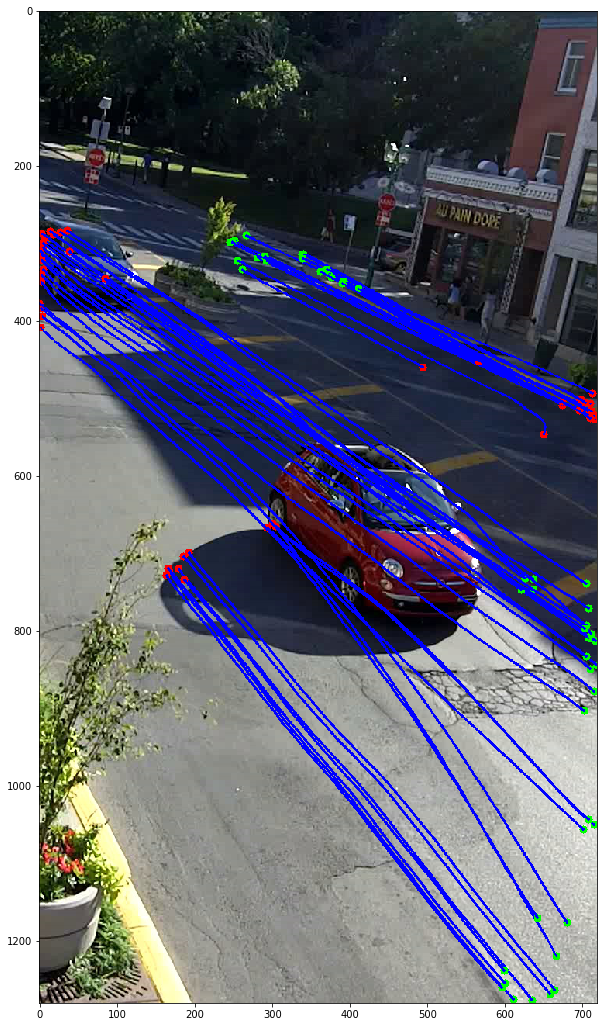

In [6]:
ut.plot_trajectories(FRAME_PATH,pixel_trajectories)

### Training data

For seq2seq trqining, we take every trajectories in the database (not only the ones selected for the clustering)

Amongst these trajectories, we select the ones having the best qualities.

In order to do that, we filter the training data considering the trajectories number of points. We take every trajectories which number of points is above a defined threshold.

(array([962., 391., 158., 100.,  54.,  46.,  32.,  15.,  23.,  11.]),
 array([ 15. ,  29.5,  44. ,  58.5,  73. ,  87.5, 102. , 116.5, 131. ,
        145.5, 160. ]),
 <a list of 10 Patch objects>)

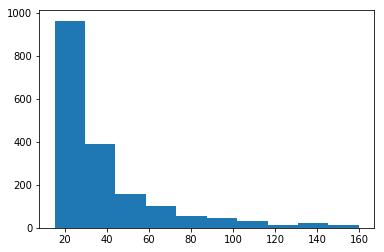

In [18]:
plt.hist([len(t) for t in trajectories_u])

filter the trajectories

In [29]:
f_u_trajectories = []
for t in trajectories_u:
    if len(t) > 80:
        f_u_trajectories.append(t)

(array([30., 24., 26., 17., 11.,  8., 10., 16.,  7.,  4.]),
 array([ 81. ,  88.9,  96.8, 104.7, 112.6, 120.5, 128.4, 136.3, 144.2,
        152.1, 160. ]),
 <a list of 10 Patch objects>)

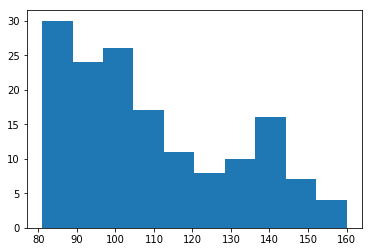

In [30]:
plt.hist([len(t) for t in f_u_trajectories])

## Trajectory discretization

In [21]:
square_size = 0.2
discretized_trajectories_u = [dtw.discretize(trajectory,square_size) for trajectory in f_u_trajectories]

(array([ 5., 11., 29., 27., 23., 19., 16., 11.,  8.,  4.]),
 array([ 54. ,  61.8,  69.6,  77.4,  85.2,  93. , 100.8, 108.6, 116.4,
        124.2, 132. ]),
 <a list of 10 Patch objects>)

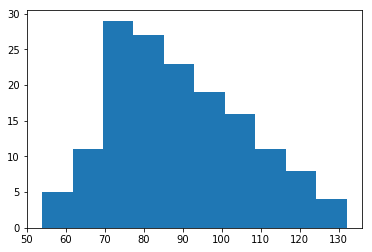

In [22]:
plt.hist([len(t) for t in discretized_trajectories_u])

## Features extraction

### filtered trajectories

In [31]:
diff_x,diff_y,diff_v,diff_r = s2s.extract_features(f_u_trajectories)
seq2seq_features = [s2s.behavior_feature_extraction(diff_x[i],diff_y[i],diff_v[i],diff_r[i]) for i in range(len(diff_x))]

seq2seq_data = s2s.minmax_scale_append_eos(seq2seq_features)

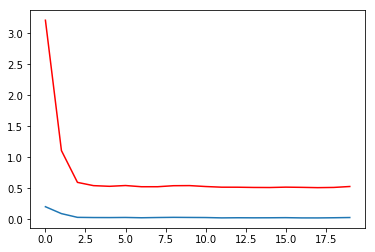

duration: 30.381980896


In [33]:
encoder = s2s.seq2seq(seq2seq_data,hidden_size = 40,n_iters = 500)

Les paramètres n'ont pas une grande influence sur l'erreur minimum atteinte sur l'ensemble de test
En revanche, ils ont une influence sur la rapidité de convergence
En filtrant les trajectoires par la taille et en conservant uniquement celles au dessus de 80 points, la convergence
est plus rapide

### filtered discretized trajectories

In [84]:
diff_x,diff_y,diff_v,diff_r = s2s.extract_features(f_d_u_trajectories)
seq2seq_features = [s2s.behavior_feature_extraction(diff_x[i],diff_y[i],diff_v[i],diff_r[i]) for i in range(len(diff_x))]

seq2seq_data = s2s.minmax_scale_append_eos(seq2seq_features)

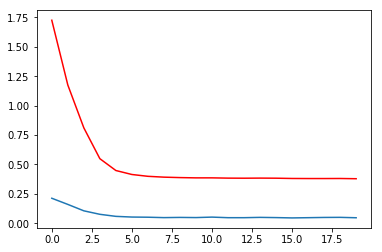

duration: 22.3014628887


In [85]:
encoder = s2s.seq2seq(seq2seq_data,hidden_size = 50)

la discrétisation n'améliore pas la performance mais permet de réduire le temps de calcul avec une convergence moins rapide

##### Retrain the encoder on the whole dataset

In [41]:
encoder = s2s.seq2seq(seq2seq_data,hidden_size = 40,train_ = 0)

best loss is: 0.0172262713313
duration: 21.2867739201


#### Get the fixed size representations of the trajectories selected for the clustering

In [42]:
diff_x,diff_y,diff_v,diff_r = s2s.extract_features(trajectories)
seq2seq_features = [s2s.behavior_feature_extraction(diff_x[i],diff_y[i],diff_v[i],diff_r[i]) for i in range(len(diff_x))]

seq2seq_data = s2s.minmax_scale_append_eos(seq2seq_features)

In [43]:
features = s2s.unify_trajectory_sizes(encoder,seq2seq_data)

### Observations

The best results are obtained by taking a subset of the whole trajectories for the training. for example, the best here is to take trajectories
which number of points are above 80

### PCA

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
features_pca = pca.fit_transform(features)
pca.n_components_

6

By applying PCA, we can keep 99% of the data variance with only 6 dimensions

# Clustering evaluation

In [16]:
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.metrics import pairwise_distances,homogeneity_completeness_v_measure,silhouette_score,calinski_harabaz_score

## Supervised

COnsidering the fact that, the trajectories are initially grouped by object, we can evaluate the quality of the clustering, using these groups as ground truth. And setting the number of clusters required to the number of objects in the database

In [17]:
#get the ground truth
labels_true = ce.get_ground_truth(ids,ids_po)  

### KMEANS

For k-means, take the mean/best performance over a certain number of iterations due to the randomness of initialization.
We use v-measure for evaluation

In [45]:
best_random_state = ce.best_model_rand_init(100,features_pca,labels_true,nb_objects)

clusters = KMeans(n_clusters=nb_objects, random_state = best_random_state).fit_predict(features_pca)

(0.5737478255277023, 0.6790909755051139, 0.6219905868342269)


## Hierarchical

In [46]:
clusters = AgglomerativeClustering(n_clusters = nb_objects).fit_predict(features_pca)
homogeneity_completeness_v_measure(labels_true, clusters)

(0.5394827452075773, 0.6909889727641619, 0.6059084861364293)

## K-MEDOIDS

In [48]:
start = time.time()

distance_matrix = pairwise_distances(features_pca,metric="manhattan")
medoids_idx, clusters =pam.pam(distance_matrix, nb_objects)

print(time.time() - start)
homogeneity_completeness_v_measure(labels_true, clusters)

0.0686800479889


(0.6834342663717359, 0.7231194831696235, 0.7027170254109205)

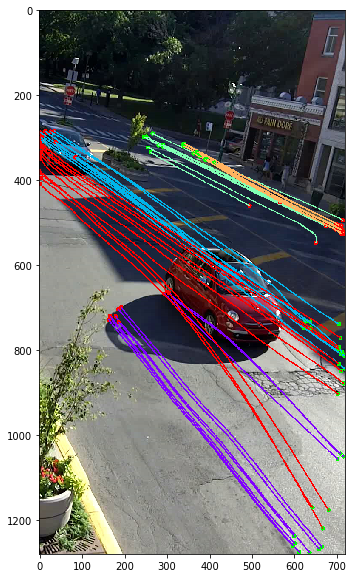

In [40]:
ut.plot_trajectories_by_groups(FRAME_PATH,pixel_trajectories_po)

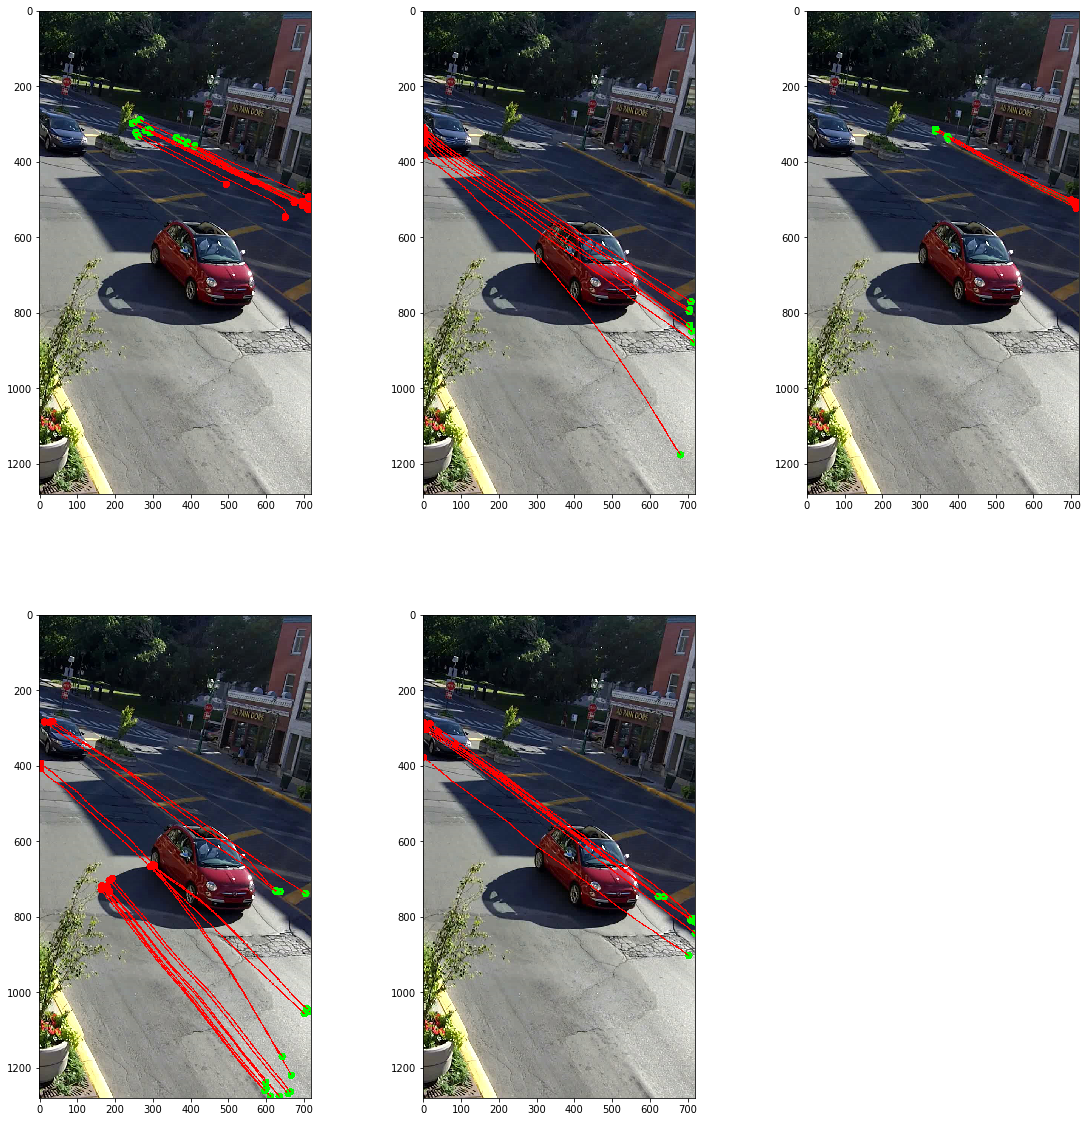

In [49]:
ut.display_clusters_oat_i(clusters,FRAME_PATH,pixel_trajectories)

## Unsupervised

In [50]:
def u_clustering_eval(max_clusters,algorithm,X):
    silhouette = []
    calinski_index = []
    for i in range(2,max_clusters):
        algorithm.set_params(n_clusters=i)
        clusters = algorithm.fit_predict(X)
        s = silhouette_score(X, clusters, metric='euclidean')
        c = calinski_harabaz_score(X, clusters) 
        silhouette.append(s)
        calinski_index.append(c)
    return silhouette, calinski_index

### KMEANS

In [51]:
max_clusters = nb_trajectories
silhouette, _ = u_clustering_eval(max_clusters,KMeans(),features_pca)
np.argmax(silhouette)+2,np.max(silhouette)

(2, 0.7587461183466137)

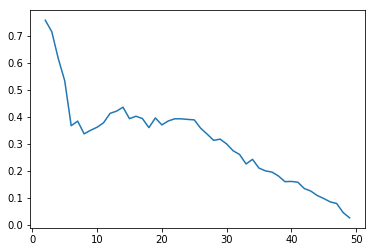

In [52]:
plt.plot(np.arange(2,max_clusters,1),silhouette)

### Hierarchical

In [53]:
max_clusters = nb_trajectories
silhouette, _ = u_clustering_eval(max_clusters,AgglomerativeClustering(),features_pca)
np.argmax(silhouette)+2,np.max(silhouette)

(2, 0.7587461183466137)

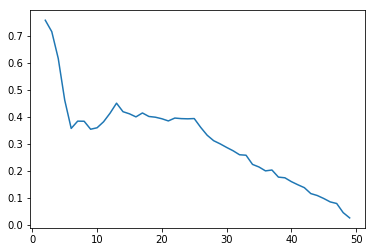

In [55]:
plt.plot(np.arange(2,max_clusters,1),silhouette)

### PAM

In [56]:
max_clusters = nb_trajectories
silhouette = []
calinski_index = []
for i in range(2,max_clusters):
    distance_matrix = pairwise_distances(features_pca,metric="manhattan")
    medoids_idx, clusters =pam.pam(distance_matrix, i)
    s = silhouette_score(features_pca, clusters, metric='euclidean')
    c = calinski_harabaz_score(features_pca, clusters) 
    silhouette.append(s)
    calinski_index.append(c)

In [57]:
np.argmax(silhouette)+2,np.max(silhouette)

(2, 0.7587461183466137)

In [72]:
nb_clusters = 2

In [73]:
clusters = KMeans(n_clusters=nb_clusters).fit_predict(features_pca)

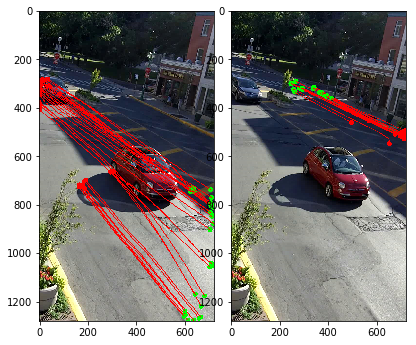

In [74]:
ut.display_clusters_oat_i(clusters,FRAME_PATH,pixel_trajectories)

### Stats about clusters

mean x

<BarContainer object of 2 artists>

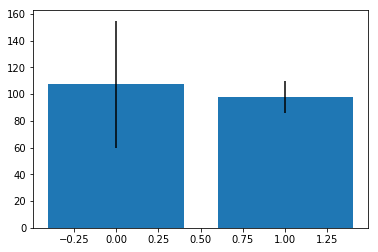

In [75]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,0],yerr = stats[:,1,0])

mean y

<BarContainer object of 2 artists>

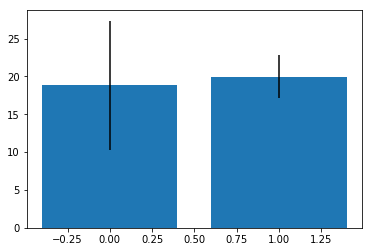

In [76]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,1],yerr = stats[:,1,1])

mean velocity of a cluster

<BarContainer object of 2 artists>

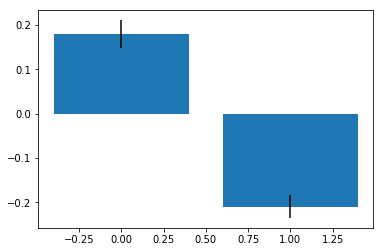

In [77]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,2],yerr = stats[:,1,2])

mean rate of turn of a cluster

<BarContainer object of 2 artists>

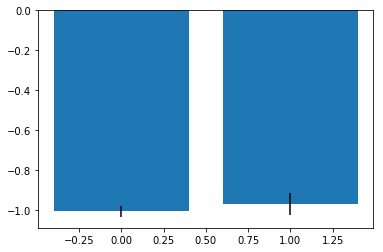

In [78]:
plt.bar(np.arange(0,nb_clusters),stats[:,0,3],yerr = stats[:,1,3])

# Observations/Conclusions

On a pu observer que la discrétisation nuit à l'entraînement du modèle et ralentit notament la vitesse de convergence.

On utilisera la pca qui permet de conserver 99% de la variance des données en réduisant les dimensions de 40 à 6.

On a pu observer avec une méthode d'évaluation supervisée que l'approche deep learning donne des résultats corrects,
cependant ils sont moins bons que les ceux obtenus avec les deux autres approches.

La différence de performance observée peut-être due au dataset, avant de conclure sur l'efficacité de cette méthode, on la testera sur le dataset "rené-lesvesques" qui possède plus de trajectoires et de natures plus variées.

Lors de l'étude supervisée des performances, k-médoids obtient les meilleurs résultats.

Lors de l'étude non-supervisée des performances les trois algorithmes proposent comme meilleure solution un clustering de 2 clusters (ce qui est loin du nombre d'objets différents dans la base de donnée, soit 5). 

Cependant, le clustering proposé reste cohérent.

Les statistiques observées permettent de remarquer que dans cette configuration, les clusters ont été principalement discriminés le sens de leur vitesse.

Les statistiques permettent de vérifier que les trajectoires ont été regroupées selon des critères cohérents.